In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import os
import random
import time
import ast

# Revised Implementation

### Data

In [2]:
df_BOM = pd.DataFrame({
    'operation': ['F.10', 'F.20', 'D.10', 'C.10', 'A.10', 'A.20'],
    'predecessor_operations': [[], ['F.10'], [], ['D.10', 'F.20'], [], ['A.10', 'C.10']],
    'end_product': [0, 0, 0, 0, 0, 1],
    'due_date': [0, 0, 0, 0, 0, 14],
    'processing_time': [2, 3, 3, 1, 5, 2],
    'workcenter': ["WC#2", "WC#1", "WC#1", "WC#1", "WC#1", "WC#2"],
    'machine': ['M1', 'M1', 'M1', 'M1', 'M1', 'M1']
})
display(df_BOM)
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2"],
    'M1': [1, 1]
})
display(df_machine)

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,F.10,[],0,0,2,WC#2,M1
1,F.20,[F.10],0,0,3,WC#1,M1
2,D.10,[],0,0,3,WC#1,M1
3,C.10,"[D.10, F.20]",0,0,1,WC#1,M1
4,A.10,[],0,0,5,WC#1,M1
5,A.20,"[A.10, C.10]",1,14,2,WC#2,M1


,workcenter,M1
0,WC#1,1
1,WC#2,1


### Class Definitions

In [3]:
class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = str(id)
        self.machines = dict_machines
        # dict_machines = {'M1': [ [], [], [] ] }
        # this means that there are 3 M1 machines
        # the [] nested inside the list refers to the usage timings of the i-th M1 machine
        # for example: [ [(0,3), (4,5)], [], []]
        # means that the 1st machine is used from (0,3) and (4,5)

class Operation:
    def __init__(self, id, processing_time, workcenter, machine, due_date=None, successors=None, predecessors=None):
        self.id = str(id)
        # Precedence constraints
        self.successor = str(successors) if successors else None
        # key assumption: each operation only has 1 successor
        self.predecessors = predecessors if predecessors else []

        # Workcenter and machine information
        self.workcenter = str(workcenter)
        self.machine = str(machine)

        # Times
        self.processing_time = processing_time
        self.start_time = None
        self.end_time = None
        self.due_date = None if due_date != due_date else due_date

        # Other
        self.scheduled = False

In [4]:
def load_operations_from_df(df, filename=None):
    operations = {}

    for index, row in df.iterrows():
        # print(row)
        op = Operation(
            id=str(row['operation']),
            processing_time=row['processing_time'],
            workcenter=row['workcenter'],
            machine=row['machine'],
            due_date=row['due_date'],
            predecessors=row['predecessor_operations']
        )
        # if filename == '100operations_10machines_0.15p_0.25D_(1000, 1500)dd.csv':
        #     print(type(op.id), op.id)
        operations[op.id] = op

    for index, row in df.iterrows():
        current_op_id = row['operation']
        predecessor_ops = row['predecessor_operations']
        # print(type(predecessor_ops))
        # print(predecessor_ops)
        for predecessor in predecessor_ops:
            # if filename == '100operations_10machines_0.15p_0.25D_(1000, 1500)dd.csv':
            #     print(type(predecessor))
            #     print(predecessor)
            #     print(type(predecessor_ops))
            #     print(predecessor_ops)
            #     # print(current)
            #     print(type(operations))
            #     print(operations)
            operations[predecessor].successor = current_op_id
    
    return operations

def load_factory(df_machine):
    factory = {}
    for idx, row in df_machine.iterrows():
        workcenter = row['workcenter']
        dict_machines = {}
        for machine in (df_machine.columns[1:]): 
            dict_machines[machine] = [[] for _ in range(row[machine])]
        # factory.append(WorkCenter(workcenter, dict_machines=dict_machines))
        factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)
    return factory 

# test case for load_operations_from_df
operations = load_operations_from_df(df_BOM)
for operation_key in operations.keys():
    print(f"{operations[operation_key].id} - successor: {operations[operation_key].successor}, predecessors: {operations[operation_key].predecessors}")

F.10 - successor: F.20, predecessors: []
F.20 - successor: C.10, predecessors: ['F.10']
D.10 - successor: C.10, predecessors: []
C.10 - successor: A.20, predecessors: ['D.10', 'F.20']
A.10 - successor: A.20, predecessors: []
A.20 - successor: None, predecessors: ['A.10', 'C.10']


### LETSA Functions

In [11]:
# FUNCTIONS 
def find_critical_path_revised(operations, feasible_operations): 
    """
    Finds the critical path among the feasible operations.
    Inputs:
        - operations                    : dictionary {operation_id: Operation()}, a dictionary of all operations.
        - feasible_operations           : list[operation_id],  a list of operation IDs that are currently feasible.
    Output:
        - critical_path, critical_length
    """

    def dfs(operations, current_op_id, path, path_length, all_paths):
        path.append(current_op_id)
        path_length += operations[current_op_id].processing_time
        
        if not operations[current_op_id].predecessors:
            all_paths.append((list(path), path_length))
        else:
            for pred in operations[current_op_id].predecessors:
                dfs(operations, pred, path, path_length, all_paths)
        
        path.pop()
        path_length -= operations[current_op_id].processing_time

    def find_all_paths(operations, feasible_operations):
        all_paths = []
        for op_id in feasible_operations:
            dfs(operations, op_id, [], 0, all_paths)
        return all_paths

    all_paths = find_all_paths(operations, feasible_operations)
    # print("     printing all paths")
    # for path in all_paths: 
        # print(path[0], path[1])
    critical_path, critical_length = max(all_paths, key=lambda x:x[1])

    return critical_path, critical_length

def schedule_operations(operations, factory):
    """
    Solves the assembly scheduling problem (ASP) using the Longest End Time Scheduling Algorithm (LETSA).
    Inputs:
        - operations            : dictionary {operation_id: Operation()}, a dictionary of all operations.
        - factory               : list [WorkCenter()], a list of WorkCenter objects, containing machine information and availability
    Output:
        - scheduled_operations  : list [Operation()], a list of Operation objects with start and end time schedules.
    """

    scheduled_operations = []
    # [[Step 4]]
    i = 1
    while True:
        # print(f"Iteration {i}")
        # ================================================================================================================
        #  [[4.0]] Feasible operations = every operation that is 
        #                               (1) not scheduled, and 
        #                               (2) has all successors scheduled, OR does not have any successors
        # ================================================================================================================
        feasible_operations = [op_id for op_id, op in operations.items() if ((not op.scheduled) and (op.successor==None or operations[op.successor].scheduled))]
        # feasible_operations = [op_id for op_id, op in operations.items() if (not op.scheduled) and (operations[op.successor].scheduled)]
        # print(f"feasible operations: {feasible_operations}")
        if not feasible_operations:
            break # terminate if all operations have been scheduled

        # ===================================================================
        #  [[4.1 - 4.3]] Compute critical path only for feasible operations
        # ===================================================================
        critical_path, length = find_critical_path_revised(operations, feasible_operations)
        selected_operation_id = critical_path[0]
        selected_operation = operations[selected_operation_id]
        # print(f"critical path: {critical_path}, length: {length}")
        # print(f"selected operation: {selected_operation_id}")

        # =====================================================================
        # [[4.4]] Set completion/end time of the selected operation as
        #         (ii) the start time of the successor, if a successor exists
        #         (ii) the project deadline, otherwise 
        # =====================================================================
        if selected_operation.successor: 
            # if the operation has a successor 
            # then the tentative end time is the start time of the successor
            successor_id = selected_operation.successor
            tentative_completion_time = operations[successor_id].start_time
        else: 
            # else, the operation is an end product and its tentative completion time must be its own deadline
            tentative_completion_time = selected_operation.due_date

        # ============================================================================
        #   [[4.5]] For each identical machine incuded in the required work-center 
        # ============================================================================
        def check_availability(time, machine_usage): 
            """
            Returns True if the time interval does not overlap with any intervals in machine_usage, False otherwise.
                time            : (start, end)
                machine_usage   : [(0,3), (4,5)]
            """
            start, end = time
            for interval in machine_usage:
                interval_start, interval_end = interval
                if not (end <= interval_start or start >= interval_end):
                    return False
            return True

        def find_latest_start_time(completion_time, processing_time, machine_usage):
            """
            completion_time : float
            processing_time : float
            machine_usage   : list of tuples [(start1, end1), (start2, end2), ...]
            
            Returns the latest possible start time such that the job can be completed
            before the completion time and does not overlap with any intervals in machine_usage.
            """
            latest_start_time = completion_time - processing_time

            # Sort the machine usage intervals by their start times
            machine_usage = sorted(machine_usage, key=lambda x: x[0])
            
            # Iterate over the machine usage intervals in reverse order
            for interval in reversed(machine_usage):
                interval_start, interval_end = interval
                
                # Check if there is a gap between the intervals where the job can fit
                if interval_end <= latest_start_time:
                    if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
                        return latest_start_time
                latest_start_time = min(latest_start_time, interval_start - processing_time)
            
            # Check if the latest possible start time is valid
            if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
                return latest_start_time
            
            return None

        current_workcenter_id = str(selected_operation.workcenter)
        current_workcenter = factory[current_workcenter_id]             # WorkCenter object 
        machine_type = str(selected_operation.machine)                       # machine id of required machine
        possible_machines = current_workcenter.machines[machine_type]   # [[], [], []]

        processing_time = selected_operation.processing_time
        tentative_start_time = tentative_completion_time - processing_time
        possible_start_times = []
        for machine_idx, machine_schedule in enumerate(possible_machines):
            # print(machine_idx, machine_schedule)
            # if not machine_schedule:  # If machine schedule is empty, then machine is immediately useable
            #     latest_available_start_time = tentative_completion_time - selected_operation.processing_time
            if check_availability((tentative_start_time, tentative_completion_time), machine_schedule) :
                # available_start_time = machine_schedule[-1][1]  # Get the end time of the last scheduled operation on this machine
                # available_start_time = machine_schedule[0][1]  # Get the end time of the last scheduled operation on this machine                
                start_time, end_time = tentative_start_time, tentative_completion_time
            else: 
                start_time = find_latest_start_time(tentative_completion_time, processing_time, machine_schedule) 
                end_time = start_time + processing_time
            possible_start_times.append((machine_idx, start_time, end_time))
            # print(start_time, end_time)

        # ============================================================================
        #   [[4.6]] Select a machine to schedule operation Jc  
        # ============================================================================
        selected_machine, finalized_start_time, finalized_end_time = max(possible_start_times, key=lambda x:x[1]) 
        current_workcenter.machines[machine_type][machine_idx].append((finalized_start_time, finalized_end_time))

        # ============================================================================
        #   [[4.7]] Delete operation Jc from the network
        #   [[4.8]] Add all eligible operations into the list of feasible operations     
        # ============================================================================
        selected_operation.start_time = start_time
        selected_operation.end_time = end_time
        selected_operation.scheduled = True
        scheduled_operations.append(selected_operation)

        i += 1 
        # print()
        
    return scheduled_operations

# def plot_gantt_chart(scheduled_operations, plot_path=None, plot_name=None):   
#     fig, ax = plt.subplots(figsize=(20, 6))

#     # Get unique work centers
#     print(type(scheduled_operations))
#     workcenters = list(set(op.workcenter for op in scheduled_operations))
    
#     # Generate colors for each work center
#     colors = dict(zip(workcenters, plt.cm.tab20.colors[:len(workcenters)]))

#     for op in scheduled_operations:
#         start = op.start_time
#         end = op.end_time
#         ax.barh(op.workcenter, end - start, left=start, color=colors[op.workcenter], edgecolor='black')
#         ax.text(start + (end - start) / 2, op.workcenter, op.id, ha='center', va='center', color='black')

#     ax.set_xlabel('Time')
#     ax.set_ylabel('Work Center')
#     ax.set_title('Gantt Chart of LETSA (and optimal) schedule')
#     ax.set_yticks(workcenters)
#     ax.set_yticklabels(workcenters)
#     ax.grid(True, which='both', linestyle='--', linewidth=0.5)

#     if plot_path: 
#         # plt.show()
#         plt.savefig(f"{plot_path}//{plot_name}.png")

def plot_gantt_chart(scheduled_operations, plot_path=None, plot_name=None):   
    fig, ax = plt.subplots(figsize=(20, 20))

    # Get unique work centers
    workcenters = list(set(str(op.workcenter) for op in scheduled_operations))
    # print(f"Unique workcenters: {workcenters}")
    # print(workcenters)

    # Generate colors for each work center
    available_colors = plt.cm.tab20.colors
    num_colors = len(available_colors)
    colors = {workcenter: available_colors[i % num_colors] for i, workcenter in enumerate(workcenters)}
    # print(f"Colors dictionary: {colors}")

    for op in scheduled_operations:
        workcenter = str(op.workcenter)
        # print(f"Processing operation {op.id} for workcenter {workcenter}")
        
        start = op.start_time
        end = op.end_time
        
        if workcenter not in colors:
            print(f"Workcenter {workcenter} not found in colors dictionary")
            continue
        
        ax.barh(workcenter, end - start, left=start, color=colors[workcenter], edgecolor='black')
        ax.text(start + (end - start) / 2, workcenter, op.id, ha='center', va='center', color='black')

    ax.set_xlabel('Time')
    ax.set_ylabel('Work Center')
    ax.set_title('Gantt Chart of LETSA schedule')
    ax.set_yticks(range(len(workcenters)))
    ax.set_yticklabels(workcenters)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    if plot_path: 
        plt.savefig(f"{plot_path}//{plot_name}.png")
        plt.close(fig)
        plt.clf()


### Implementation

[<__main__.Operation object at 0x00000180390458D0>, <__main__.Operation object at 0x0000018039046F50>, <__main__.Operation object at 0x0000018039047BD0>, <__main__.Operation object at 0x0000018039045AD0>, <__main__.Operation object at 0x0000018038FEAA50>, <__main__.Operation object at 0x0000018039044C90>]


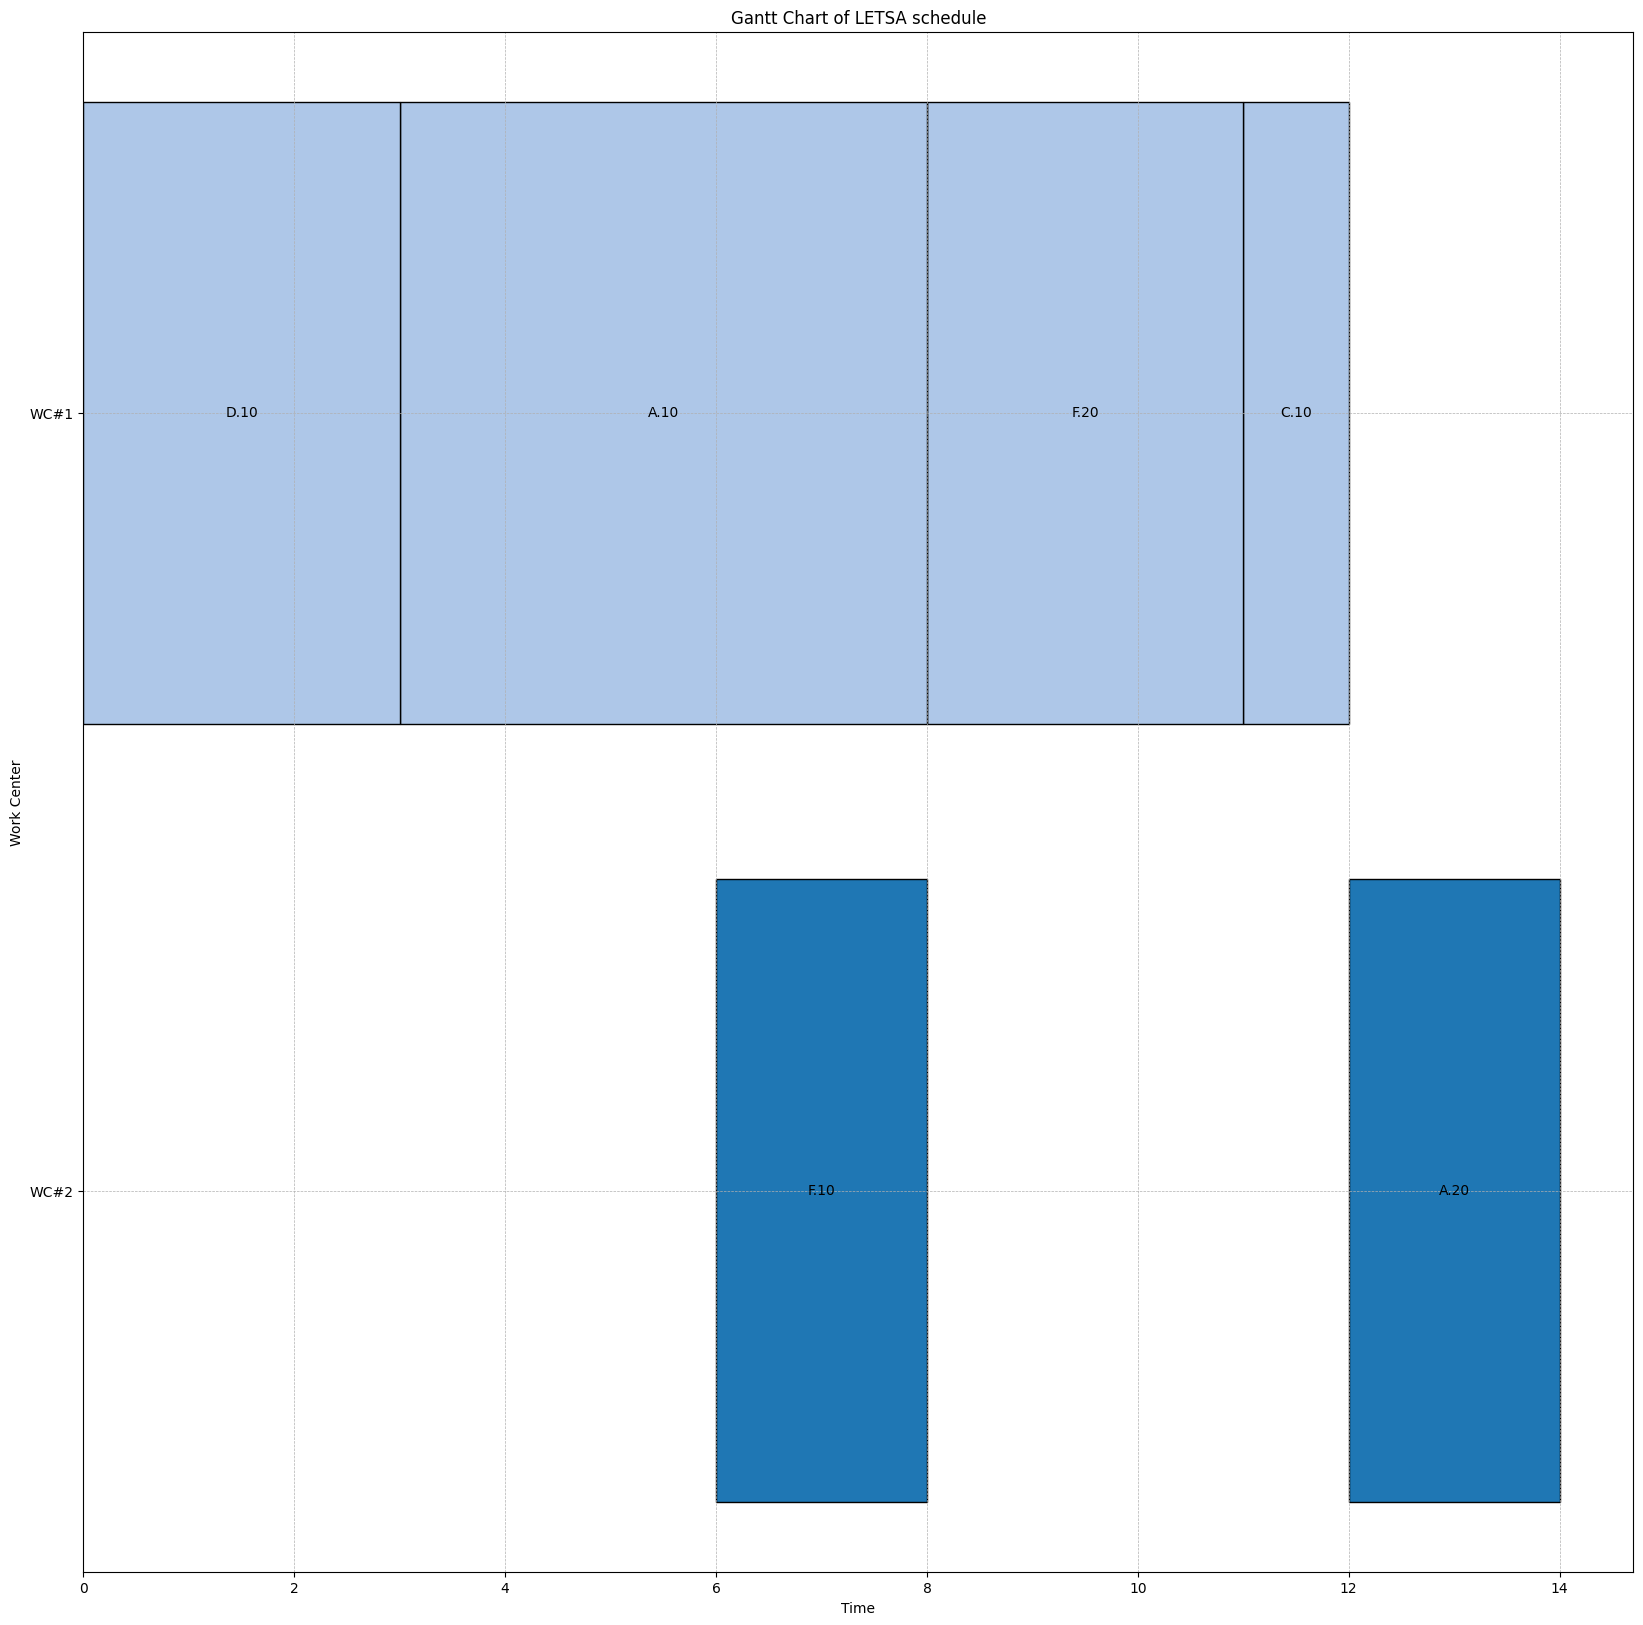

In [6]:
factory = load_factory(df_machine)
operations = load_operations_from_df(df_BOM)
scheduled_operations = schedule_operations(operations, factory)
plot_gantt_chart(scheduled_operations)
print(scheduled_operations)

# Test Case

### Basic Test Case

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,A,[],0,NaN,3,WC#2,M1
1,B,[],0,NaN,2,WC#1,M2
2,C,[A],0,NaN,1,WC#1,M3
3,D,[B],0,NaN,3,WC#2,M2
4,E,"[C, D]",0,NaN,1,WC#2,M4


,workcenter,M1,M2,M3,M4,M5
0,WC#1,3,2,1,1,1
1,WC#2,2,1,2,1,2
2,WC#3,3,2,1,1,3


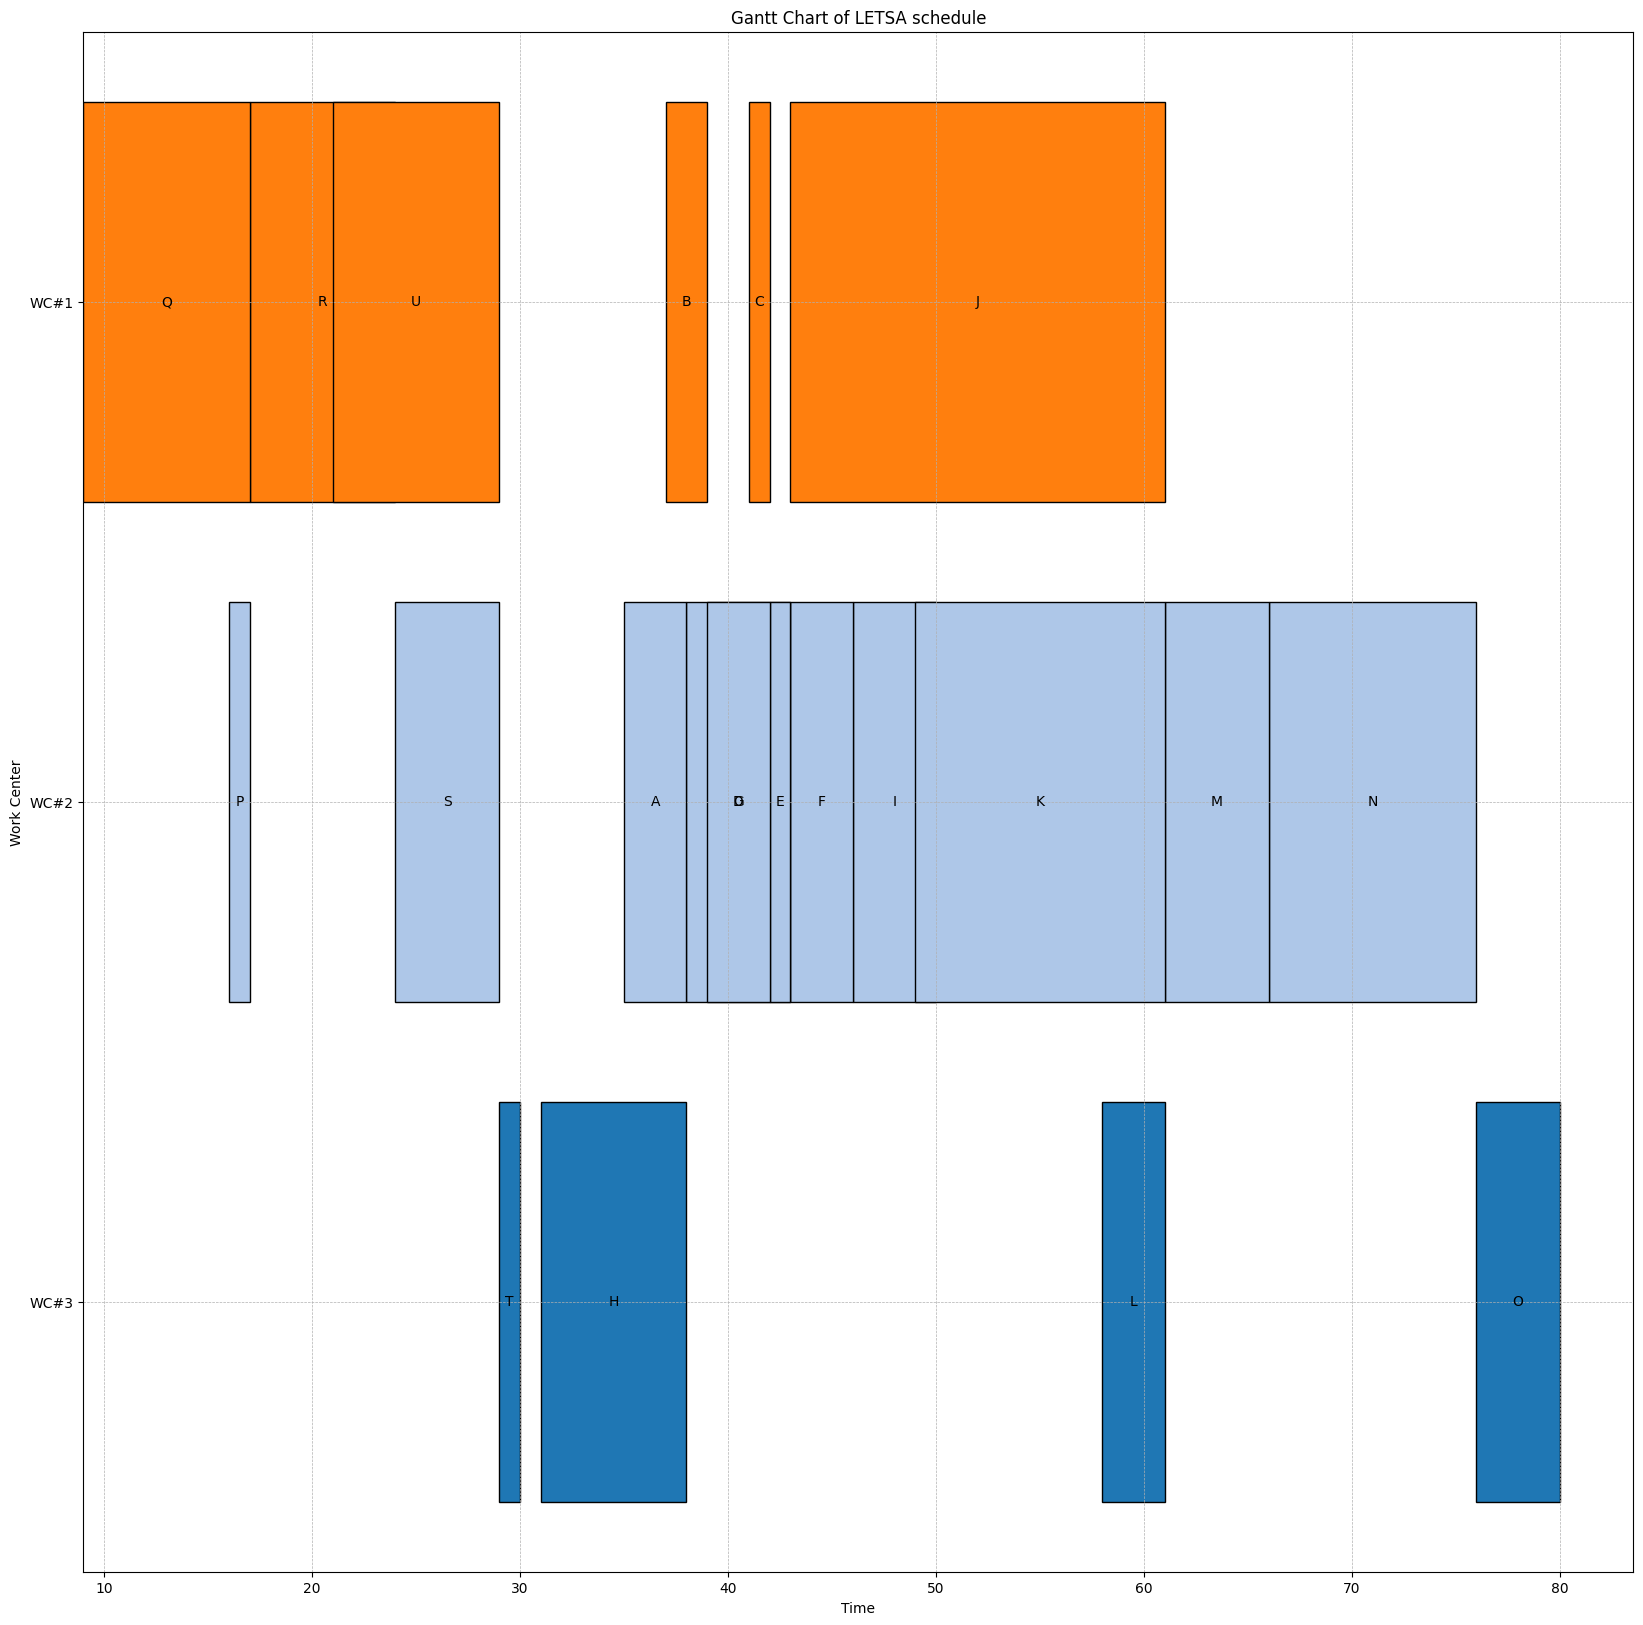

In [7]:
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
    'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None],
    'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
    'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
    'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
})
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2", "WC#3"],
    'M1': [3, 2, 3],
    'M2': [2, 1, 2],
    'M3': [1, 2, 1],
    'M4': [1, 1, 1],
    'M5': [1, 2, 3]
})
display(df_BOM.head())
display(df_machine.head())

factory = load_factory(df_machine)
operations = load_operations_from_df(df_BOM)
# for operation_key in operations.keys():
#     print(f"{operations[operation_key].id} - successor: {operations[operation_key].successor}, predecessors: {operations[operation_key].predecessors}")
scheduled_operations = schedule_operations(operations, factory)

plot_gantt_chart(scheduled_operations)

### Systematic Testing

In [8]:
# GENERATING THE FACTORY INFORMATION
random.seed(42)
n_workcenters = 100
n_machines = 20 

df_machine = pd.DataFrame({
    'workcenter': [f"{i}" for i in range(1,n_workcenters+1)],
})

for machine_no in range(1,n_machines+1): 
    machine_name = f"{machine_no}"
    df_machine[machine_name] = [random.randint(1,3) for _ in range(1, n_workcenters+1)] 
display(df_machine.head())

,workcenter,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1,3,3,1,1,1,1,2,1,2,...,3,1,2,2,1,3,3,3,1,1
1,2,1,3,1,2,1,2,2,3,1,...,2,1,2,2,1,2,2,2,2,1
2,3,1,3,3,3,2,1,2,1,3,...,3,2,3,1,3,1,2,1,1,2
3,4,3,1,1,1,2,2,2,1,3,...,3,3,2,1,2,2,3,1,3,1
4,5,2,3,1,1,1,1,3,2,3,...,3,3,1,3,3,2,3,3,2,2


In [9]:
import sys 
def print_progress_bar(iteration, total, length=50):
    if iteration == 0:
        return  # Don't print the progress bar when no progress has been made.
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = '█' * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r|{bar}| {percent}% Complete')
    sys.stdout.flush()
    if iteration == total:
        print()

In [14]:
# SYSTEMATIC TESTING

files = os.listdir('TestCases') 
files = [file for file in files if file[-3:] == "csv"]
total_files = len(files)
df_results = pd.DataFrame({
    'filename': [None],
    'processing_time': [None]
})

list_workcenters, list_machines = [], []
folder_path = 'LETSA_testcase'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

i = 0
for filename in files: 
    df_BOM = pd.read_csv(f"TestCases//{filename}")
    df_BOM['predecessor_operations'] = df_BOM['predecessor_operations'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

    start = time.time()

    factory = load_factory(df_machine)
    operations = load_operations_from_df(df_BOM, filename=filename)
    scheduled_operations = schedule_operations(operations, factory)
    # plot_gantt_chart(scheduled_operations, plot_path=folder_path, plot_name=filename[:-4])

    end = time.time()

    processing_time = end - start
    # print(f"{i:>5}  {filename:>80}  {processing_time:>5.2f}")
    df_results.at[i, 'filename'] = filename
    df_results.at[i, 'processing_time'] = processing_time

    if i // 50 == 1:
        df_results.to_csv("LETSA_results.csv", index=False)
    i += 1  
    print_progress_bar(i, total_files)

|██████████████████████████████████████████████████| 100.0% Complete


In [15]:
df_results.to_csv("LETSA_results.csv", index=False)

In [ ]:
# #  DEBUGGING
# # ===========

# files = os.listdir('TestCases') 
# files = [file for file in files if file[-3:] == "csv"]
# df_results = pd.DataFrame({
#     'filename': [None],
#     'processing_time': [None]
# })
# # display(df_results)

# list_workcenters, list_machines = [], []
# folder_path = 'LETSA_testcase'
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# i = 0
# for filename in files: 
#     if filename == '200operations_10machines_0.4p_0.25D_(2000, 5000)dd.csv': 
#         print(filename)
#         df_BOM = pd.read_csv(f"TestCases//{filename}")
#         display(df_BOM)
#         display(df_BOM.dtypes)
#         # df_BOM['operation'] = df_BOM['operation'].dropna().astype(int).astype(str)
#         df_BOM['predecessor_operations'] = df_BOM['predecessor_operations'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

#         start = time.time()
#         factory = load_factory(df_machine)
#         if filename == '100operations_10machines_0.15p_0.25D_(1000, 1500)dd.csv':
#             operations = load_operations_from_df(df_BOM, filename=filename)
#         else: 
#             operations = load_operations_from_df(df_BOM)
#         scheduled_operations = schedule_operations(operations, factory)
#         plot_gantt_chart(scheduled_operations, plot_path=folder_path, plot_name=filename[:-4])

#         end = time.time()
#         processing_time = end - start
#         # print(f"{i:>5}  {filename:>80}  {processing_time:>5.2f}")
#         df_results.at[i, 'filename'] = filename
#         df_results.at[i, 'processing_time'] = processing_time

#         if i // 100 == 1:
#             df_results.to_csv("LETSA_results.csv", index=False)
#         i += 1
#         print("success! \n")